In [1]:
import warnings
import torch
from molecule import MoleculeTrainer
from gflownet.config import init_empty, Config
from rdkit.Chem.Draw import MolsToGridImage

No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!
Skipped loading some Tensorflow models, missing a dependency. No module named 'tensorflow'
wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.
Skipped loading modules with transformers dependency. No module named 'transformers'
cannot import name 'HuggingFaceModel' from 'deepchem.models.torch_models' (d:\Dokumenter\Skole\Prosjektoppgave\prosjektKopi\pom_cpu-model\venv\lib\site-packages\deepchem\models\torch_models\__init__.py)
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'lightning'
Skipped loading some Jax models, missing a dependency. No module named 'jax'
Skipped loading some PyTorch models, missing a dependency. No module named 'tensorflow'


In [2]:
# Suppress FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Run on cpu
dev = torch.device('cpu')





In [3]:
# Training data
vanillin_smiles = ["[H]C(=O)C1=CC(OC)=C(O)C=C1"]

In [ ]:
# Initialize model
config = init_empty(Config())
config.print_every = 1
config.log_dir = "save_test"
config.device = dev
config.num_training_steps = 10
config.num_workers = 0
config.num_validation_gen_steps = 1
config.overwrite_existing_exp=False
config.checkpoint_every = 2
config.algo.max_nodes = 12 # 95 quantil
config.store_all_checkpoints = True

trial = MoleculeTrainer(config,vanillin_smiles, print_config=True)
trial.run()



Hyperparameters:

desc: noDesc
log_dir: save_test
device: cpu
seed: 0
validate_every: 1000
checkpoint_every: 2
store_all_checkpoints: false
print_every: 1
start_at_step: 0
num_final_gen_steps: null
num_validation_gen_steps: 1
num_training_steps: 10
num_workers: 0
hostname: null
pickle_mp_messages: false
git_hash: f106cde
overwrite_existing_exp: false
algo:
  method: TB
  num_from_policy: 64
  num_from_dataset: 0
  valid_num_from_policy: 64
  valid_num_from_dataset: 0
  max_len: 128
  max_nodes: 12
  max_edges: 128
  illegal_action_logreward: -1.0
  train_random_action_prob: 0.0
  train_det_after: null
  valid_random_action_prob: 0.0
  sampling_tau: 0.9
  tb:
    bootstrap_own_reward: false
    epsilon: null
    reward_loss_multiplier: 1.0
    variant: TB
    do_correct_idempotent: false
    do_parameterize_p_b: false
    do_predict_n: false
    do_sample_p_b: false
    do_length_normalize: false
    subtb_max_len: 128
    Z_learning_rate: 0.0001
    Z_lr_decay: 50000.0
    cum_subtb:

In [15]:
type(config)

gflownet.config.Config

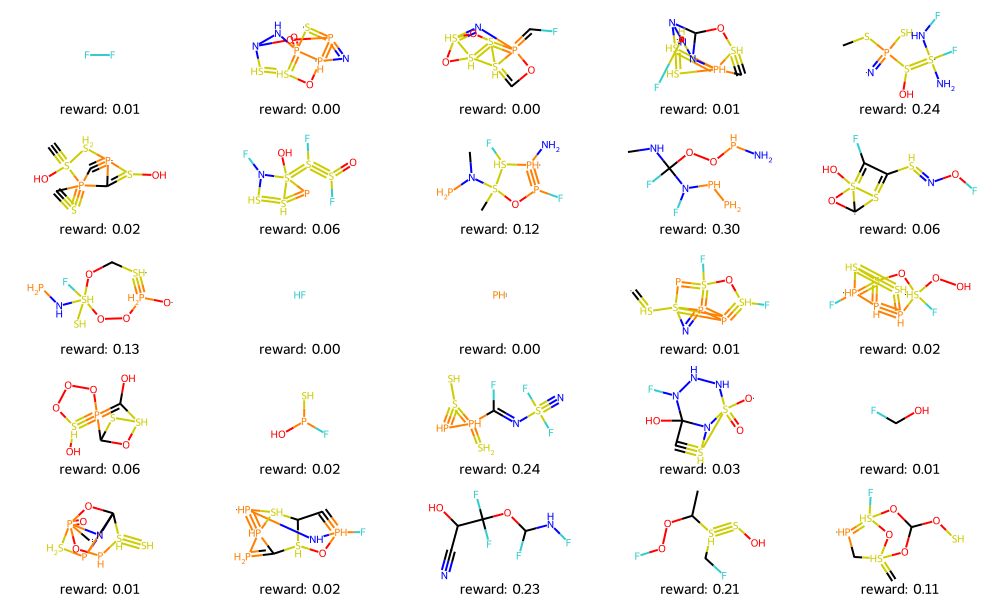

In [5]:
# Generate molecules
trajs = trial.algo.create_training_data_from_own_samples(trial.model, 25)
objs = [trial.ctx.graph_to_obj(i['result']) for i in trajs]
obj_props, _ = trial.task.compute_obj_properties(objs)
log_rewards = trial.task.cond_info_to_logreward({'beta': torch.ones(len(trajs))}, obj_props)
MolsToGridImage(objs[:25], molsPerRow=5, subImgSize=(200, 120), legends=[f'reward: {r.exp().item():.2f}' for r in log_rewards[:25]])

In [ ]:
#torch.save(trial.model, f"{config.log_dir}/save.pt")

In [7]:
trial.cfg

{'desc': 'noDesc', 'log_dir': 'save_test', 'device': 'cpu', 'seed': 0, 'validate_every': 1000, 'checkpoint_every': 2, 'store_all_checkpoints': False, 'print_every': 1, 'start_at_step': 0, 'num_final_gen_steps': None, 'num_validation_gen_steps': 1, 'num_training_steps': 10, 'num_workers': 0, 'hostname': None, 'pickle_mp_messages': False, 'git_hash': 'f106cde', 'overwrite_existing_exp': False, 'algo': {'method': 'TB', 'num_from_policy': 64, 'num_from_dataset': 0, 'valid_num_from_policy': 64, 'valid_num_from_dataset': 0, 'max_len': 128, 'max_nodes': 12, 'max_edges': 128, 'illegal_action_logreward': -1.0, 'train_random_action_prob': 0.0, 'train_det_after': None, 'valid_random_action_prob': 0.0, 'sampling_tau': 0.9, 'tb': {'bootstrap_own_reward': False, 'epsilon': None, 'reward_loss_multiplier': 1.0, 'variant': <TBVariant.TB: 0>, 'do_correct_idempotent': False, 'do_parameterize_p_b': False, 'do_predict_n': False, 'do_sample_p_b': False, 'do_length_normalize': False, 'subtb_max_len': 128, 'Z

In [9]:
import pathlib

In [17]:
  
state = {
    "models_state_dict": [trial.model.state_dict()],
    "cfg": trial.cfg,
    "env_ctx": trial.model.env_ctx,
    #"model": trial.model,
}
if trial.sampling_model is not trial.model:
    state["sampling_model_state_dict"] = [trial.sampling_model.state_dict()]
fn = pathlib.Path(trial.cfg.log_dir) / "model_final_save.pt"
with open(fn, "wb") as fd:
    torch.save(
        state,
        fd,
    )


In [11]:
type(trial.model)

gflownet.models.graph_transformer.GraphTransformerGFN